In [1]:
%load_ext autoreload

In [2]:
%run "./common_init.ipynb"

/data/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/data/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


<Figure size 432x288 with 0 Axes>

Setup logging to file: out.log
Figure output directory saved in figure_output at /home/datarian/OneDrive/unine/Master_Thesis/ma-thesis-report/figures
 cwd: /data/home/datarian/git/master-thesis-msc-statistics/code


In [3]:
%autoreload 2
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load custom code
import kdd98.data_handler as dh
from kdd98.config import Config
import pickle

Using TensorFlow backend.


In [4]:
PROJECT_ROOT_DIR = "../../"
CHAPTER_ID = "feature_extraction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "figures", CHAPTER_ID)

if not os.path.exists(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)

def save_fig(fig_id, tight_layout=True, fig_extension=["pdf", "png"], resolution=300):
    if tight_layout:
        plt.tight_layout()
    [plt.savefig(pathlib.Path(IMAGES_PATH, fig_id + "." + f), 
                 format=f,
                 dpi=resolution,
                 transparent=True,
                 bbox_inches='tight') for f in fig_extension]

In [5]:
data_provider = dh.KDD98DataProvider("cup98LRN.txt")

Before encoding categorical features

In [6]:
cleaned = data_provider.cleaned_data

With onehot / binary encoded categories and other feature engineering (zip codes to coordinates, etc.)

In [7]:
numeric = data_provider.numeric_data

## Finding relevant features

In [8]:
Xy = data_provider.imputed_data

In [9]:
Xy["data"].describe()

,RECINHSE,AGE,AGEFLAG,HOMEOWNR,NUMCHLD,INCOME,WEALTH1,HIT,MBCRAFT,MBBOOKS,...,RFA_24R_P,RFA_24R_S,RFA_24R_U,RFA_24R_nan,DOMAINUrbanicity_C,DOMAINUrbanicity_R,DOMAINUrbanicity_S,DOMAINUrbanicity_T,DOMAINUrbanicity_U,DOMAINUrbanicity_nan
count,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,...,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000
mean,0.070253,61.707972,0.910703,0.781684,1.068513,3.911625,6.652455,3.321438,0.067832,0.497956,...,0.009831,0.149583,0.000262,0.387509,0.206358,0.207416,0.229782,0.204660,0.127510,0.024274
std,0.255575,14.451513,0.285173,0.413105,0.340549,1.635685,2.025250,9.306899,0.322884,1.245737,...,0.098664,0.356664,0.016185,0.487184,0.404692,0.405458,0.420695,0.403455,0.333545,0.153898
min,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,52.000000,1.000000,1.000000,1.000000,3.000000,6.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,62.000000,1.000000,1.000000,1.000000,4.000000,7.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,71.000000,1.000000,1.000000,1.000000,5.000000,7.000000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,98.000000,1.000000,1.000000,7.000000,7.000000,10.000000,241.000000,6.000000,9.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
Xy["targets"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95412 entries, 95515 to 185114
Data columns (total 2 columns):
TARGET_B    95412 non-null int64
TARGET_D    95412 non-null float64
dtypes: float64(1), int64(1)
memory usage: 2.2 MB


### Boruta

In [11]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

In [12]:
help(BorutaPy)

Help on class BorutaPy in module boruta.boruta_py:

class BorutaPy(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  Improved Python implementation of the Boruta R package.
 |  
 |  The improvements of this implementation include:
 |  - Faster run times:
 |      Thanks to scikit-learn's fast implementation of the ensemble methods.
 |  - Scikit-learn like interface:
 |      Use BorutaPy just like any other scikit learner: fit, fit_transform and
 |      transform are all implemented in a similar fashion.
 |  - Modularity:
 |      Any ensemble method could be used: random forest, extra trees
 |      classifier, even gradient boosted trees.
 |  - Two step correction:
 |      The original Boruta code corrects for multiple testing in an overly
 |      conservative way. In this implementation, the Benjamini Hochberg FDR is
 |      used to correct in each iteration across active features. This means
 |      only those features are included in the correction which are still in
 |  

In [13]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1,
                            max_depth=6,
                            class_weight='balanced')

# define Boruta feature selection method
feat_selector = BorutaPy(rf,
                         n_estimators='auto',
                         max_iter=120,
                         perc=100, # controls how conservatively we select features. Lower means more false positives
                         verbose=2,
                         random_state=Config.get("random_seed"))

The algorithm automatically stops when no tentative features remain, or after 120 rounds.

In [14]:
feat_selector.fit(Xy["data"].values, Xy["targets"].loc[:,"TARGET_B"].astype("int64").values)

Iteration: 	1 / 120
Confirmed: 	0
Tentative: 	653
Rejected: 	0
Iteration: 	2 / 120
Confirmed: 	0
Tentative: 	653
Rejected: 	0
Iteration: 	3 / 120
Confirmed: 	0
Tentative: 	653
Rejected: 	0
Iteration: 	4 / 120
Confirmed: 	0
Tentative: 	653
Rejected: 	0
Iteration: 	5 / 120
Confirmed: 	0
Tentative: 	653
Rejected: 	0
Iteration: 	6 / 120
Confirmed: 	0
Tentative: 	653
Rejected: 	0
Iteration: 	7 / 120
Confirmed: 	0
Tentative: 	653
Rejected: 	0
Iteration: 	8 / 120
Confirmed: 	57
Tentative: 	42
Rejected: 	554


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 120
Confirmed: 	57
Tentative: 	42
Rejected: 	554


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 120
Confirmed: 	57
Tentative: 	42
Rejected: 	554


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 120
Confirmed: 	57
Tentative: 	42
Rejected: 	554


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 120
Confirmed: 	57
Tentative: 	27
Rejected: 	569


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 120
Confirmed: 	57
Tentative: 	27
Rejected: 	569


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 120
Confirmed: 	57
Tentative: 	27
Rejected: 	569


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 120
Confirmed: 	57
Tentative: 	27
Rejected: 	569


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 120
Confirmed: 	57
Tentative: 	22
Rejected: 	574


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 120
Confirmed: 	57
Tentative: 	22
Rejected: 	574


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 120
Confirmed: 	57
Tentative: 	22
Rejected: 	574


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 120
Confirmed: 	57
Tentative: 	18
Rejected: 	578


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 120
Confirmed: 	57
Tentative: 	18
Rejected: 	578


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 120
Confirmed: 	57
Tentative: 	18
Rejected: 	578


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 120
Confirmed: 	57
Tentative: 	10
Rejected: 	586


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 120
Confirmed: 	57
Tentative: 	10
Rejected: 	586


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 120
Confirmed: 	57
Tentative: 	10
Rejected: 	586


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 120
Confirmed: 	57
Tentative: 	10
Rejected: 	586


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 120
Confirmed: 	57
Tentative: 	6
Rejected: 	590


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 120
Confirmed: 	57
Tentative: 	6
Rejected: 	590


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 120
Confirmed: 	57
Tentative: 	6
Rejected: 	590


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 120
Confirmed: 	57
Tentative: 	6
Rejected: 	590


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 120
Confirmed: 	57
Tentative: 	5
Rejected: 	591


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 120
Confirmed: 	57
Tentative: 	5
Rejected: 	591


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 120
Confirmed: 	57
Tentative: 	4
Rejected: 	592


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 120
Confirmed: 	57
Tentative: 	4
Rejected: 	592


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 120
Confirmed: 	57
Tentative: 	4
Rejected: 	592


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 120
Confirmed: 	57
Tentative: 	4
Rejected: 	592


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 120
Confirmed: 	57
Tentative: 	4
Rejected: 	592


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 120
Confirmed: 	57
Tentative: 	4
Rejected: 	592


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 120
Confirmed: 	57
Tentative: 	4
Rejected: 	592


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 120
Confirmed: 	57
Tentative: 	4
Rejected: 	592


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 120
Confirmed: 	57
Tentative: 	4
Rejected: 	592


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 120
Confirmed: 	57
Tentative: 	4
Rejected: 	592


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 120
Confirmed: 	57
Tentative: 	4
Rejected: 	592


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 120
Confirmed: 	57
Tentative: 	4
Rejected: 	592


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 120
Confirmed: 	57
Tentative: 	4
Rejected: 	592


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 120
Confirmed: 	57
Tentative: 	4
Rejected: 	592


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 120
Confirmed: 	57
Tentative: 	3
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 120
Confirmed: 	57
Tentative: 	3
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 120
Confirmed: 	57
Tentative: 	3
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	99 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	100 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	101 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	102 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	103 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	104 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	105 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	106 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	107 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	108 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	109 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	110 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	111 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	112 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	113 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	114 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	115 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	116 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	117 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	118 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593
Iteration: 	119 / 120
Confirmed: 	58
Tentative: 	2
Rejected: 	593


BorutaPy finished running.

Iteration: 	120 / 120
Confirmed: 	58
Tentative: 	0
Rejected: 	593


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True,
                                          class_weight='balanced',
                                          criterion='gini', max_depth=6,
                                          max_features='auto',
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=182, n_jobs=-1,
                                          oob_score=False,
                                          random_state=<mtrand.RandomState object at 0x7f5f145dd3f0>,
                                          verbose=0, warm_start=False),
         max_iter=

In [15]:
with open(pathlib.Path(Config.get("model_store"), "feature_selection_boruta.pkl"), "wb") as of:
    pickle.dump(feat_selector, of)

Boolean mask for the features selected:

In [16]:
feat_selector.support_

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

Important features have rank 1, rank 2 are tentative, then, the ranks get progressively higher for less important features.

In [17]:
# check ranking of features
feat_selector.ranking_

array([277,   1, 443, 392, 381,  71, 287, 223, 363, 314, 368, 512, 378,
       511, 481, 346, 401, 360, 423, 331, 100, 113,  77, 202, 190, 180,
        69, 485, 458, 513, 500, 410, 435, 445, 496, 473, 515, 429, 372,
       397,   1,  32,  34,  31, 352, 328, 314, 252, 263,  13,  10, 289,
        57, 117, 475, 191, 302, 312, 310, 365, 126, 390, 418, 202,  35,
       116, 127, 104, 124, 205, 118, 119, 216, 159,  58, 171, 218, 267,
       207,  55, 124, 226, 192, 257, 239, 199,  79, 220,  92, 176,   5,
        97, 134, 177, 237,  80, 228, 279,  51,  66,  72, 130, 148, 178,
       167, 174, 242, 282, 284, 349,   1,   1, 108,  48,  90,  73, 171,
       199, 178,  73, 128,  82, 136, 185, 185,   7, 338,  15, 223, 231,
       273, 167,  56,  64,  52,  21, 145,   1,   1,   1,   1,   1,   9,
       237,  96, 140, 173, 293, 294, 141, 246, 255, 131, 142, 229, 320,
         1,   3,   7,  54,  27,  53,   1,   4,   1,   1,   1,   1,  75,
       150, 152, 164,  95,  11, 209, 109, 231,  18, 157, 124, 15

The list of selected features:

In [18]:
feature_names = Xy["data"].columns.values[feat_selector.support_]
feature_names

array(['AGE', 'PEPSTRFL', 'HV1', 'HV2', 'HVP1', 'HVP2', 'HVP3', 'HVP4',
       'HVP5', 'RP1', 'DMA', 'IC2', 'IC3', 'IC4', 'IC5', 'HHAS3', 'EC7',
       'POBC2', 'CARDPROM', 'NUMPROM', 'CARDPM12', 'NUMPRM12', 'RAMNT_14',
       'RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MAXRAMNT',
       'LASTGIFT', 'AVGGIFT', 'RFA_2F', 'RFA_2A', 'RFA_3F', 'RFA_3A',
       'RFA_4F', 'RFA_4A', 'RFA_5F', 'RFA_5A', 'RFA_6F', 'RFA_6A',
       'RFA_7F', 'RFA_7A', 'RFA_8F', 'RFA_8A', 'RFA_9F', 'RFA_9A',
       'RFA_11A', 'RFA_12A', 'RFA_13A', 'RFA_14A', 'RFA_15A', 'RFA_16A',
       'ZIP_longitude', 'LASTDATE_DELTA_MONTHS', 'MAXRDATE_DELTA_MONTHS',
       'ODATEDW_DELTA_YEARS', 'RFA_3R_S', 'RFA_4R_S'], dtype=object)

The selected features excluding RFA_*:

In [19]:
feature_names_without_RFA = [f for f in feature_names if f[:4] != "RFA_"]

The dataframe is persisted for further use:

In [20]:
Xy_all_relevant = Xy.copy()

Xy_all_relevant["data"] = Xy_all_relevant["data"].loc[:, feature_names_without_RFA]
Xy_all_relevant["feature_names"] = Xy["data"].columns.values.tolist()

with open(pathlib.Path(Config.get("df_store"), "Xy_all_relevant.pd.pkl"), "wb") as of:
    pickle.dump(Xy_all_relevant, of)

Boruta-selected features are also available conveniently from `kdd98`:

In [21]:
all_relevant = data_provider.all_relevant_data

It would now be nice to generate a pairplot of the remaining the features, but unfortunately this is beyond the resources of the machine used. Calculation

## PCA

A completely different approach to feature selection through PCA.

We can use the first $n$ principal components as new input features, compressing the information in the original data. 

In [22]:
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

PCA is initialized with the percentage of variance explained that is to be achieved. The necessary number of components is selected to meet the criteria.

In [23]:
scaled = preprocessing.StandardScaler().fit_transform(Xy["data"].values)
pca = decomposition.PCA(n_components=0.95)
pca.fit(scaled)
features_pca = pca.transform(scaled)

In [24]:
features_pca

array([[ 5.54832263e+00, -1.27380000e+01,  9.18663503e+00, ...,
        -2.53850294e-01,  8.15157269e-02,  1.03959739e-01],
       [-2.11531122e+01,  7.24868252e-01, -3.38091815e-01, ...,
        -7.12765530e-01, -3.20329713e-01,  5.31474176e-01],
       [ 7.81614792e+00, -1.05868549e+01,  5.06108265e+00, ...,
         6.55482179e-01,  6.72570633e-03,  5.10604001e-01],
       ...,
       [ 3.92533306e+00, -1.49181431e+00, -2.18465441e+00, ...,
        -6.18885886e-01, -5.03398485e-01,  3.20471990e-02],
       [-8.02389659e+00, -7.48061715e+00,  9.36808872e+00, ...,
        -4.24634587e-01,  4.64834534e-01,  1.84718444e-02],
       [-7.66594607e+00, -4.52467267e+00,  3.94814442e+00, ...,
        -3.10573286e-02,  8.60743423e-02, -2.45504288e-01]])

In [25]:
pca.components_

array([[ 0.00066436,  0.01904806,  0.00459083, ...,  0.0055132 ,
        -0.00503461, -0.00144575],
       [-0.00317863,  0.00290653, -0.00269118, ..., -0.02986225,
         0.05577906, -0.00214995],
       [ 0.02724358,  0.04505671, -0.00463347, ..., -0.01949199,
         0.02045932,  0.00563115],
       ...,
       [ 0.00192865, -0.00909539,  0.00073621, ..., -0.01004385,
         0.06116234,  0.05991661],
       [-0.00289661,  0.0029167 , -0.00759639, ..., -0.07489955,
        -0.017487  ,  0.06466446],
       [ 0.02625639,  0.02131605, -0.02834509, ...,  0.00362902,
         0.00484767,  0.00561891]])

Dimensionality is still very high for reaching even only 60% of variance explained

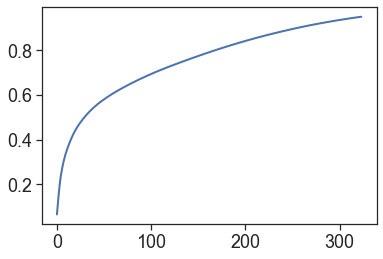

In [26]:
cum_var_expl = np.cumsum(pca.explained_variance_ratio_)
sns.lineplot(data = cum_var_expl)
plt.xlabel = "Number of dimensions"
plt.ylabel = "Variance explained"

In [27]:
pca.n_components_

324

In [28]:
pca.n_features_

653

## Sklearn SelectFromModel 

Yet another approach using scikit-learn functionality. We use a random forest classifier to determine feature importances.

Then, the $n$ most important features are selected.

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
clf = RandomForestClassifier(n_estimators=500, class_weight="balanced")
clf = clf.fit(Xy["data"].values, Xy["targets"].TARGET_B.astype("int").values)
clf.feature_importances_  

array([3.52406638e-04, 6.19923274e-03, 4.45288366e-04, 5.85887227e-04,
       3.80193249e-04, 2.43949279e-03, 1.83174877e-03, 2.36924432e-03,
       4.41296300e-04, 1.09036715e-03, 6.98604997e-04, 3.12989279e-04,
       2.71627684e-04, 3.29178692e-04, 3.18317298e-04, 8.91551445e-04,
       4.56199329e-04, 6.39492013e-04, 4.17556893e-04, 1.26647901e-03,
       4.32595313e-03, 4.50919702e-03, 4.27906248e-03, 3.42920293e-03,
       3.00632392e-03, 2.67956344e-03, 1.90422142e-03, 3.12781177e-04,
       4.05511641e-04, 4.06824074e-04, 3.65662948e-04, 4.38123557e-04,
       4.75476042e-04, 4.31037300e-04, 4.26653282e-04, 3.19962657e-04,
       3.74960286e-04, 3.54219721e-04, 4.74431006e-04, 4.36137593e-04,
       2.41766208e-03, 5.24921183e-03, 5.13690473e-03, 5.25953105e-03,
       7.37433589e-04, 1.26724492e-03, 1.29804158e-03, 2.14864261e-03,
       2.04653221e-03, 2.89158347e-03, 2.36368511e-03, 1.16988653e-03,
       1.76842258e-03, 2.45848899e-03, 4.80164025e-04, 5.62905636e-04,
      

In [30]:
importances = pd.DataFrame(data=clf.feature_importances_, index=Xy["data"].columns.values.tolist(), columns=["importance"])

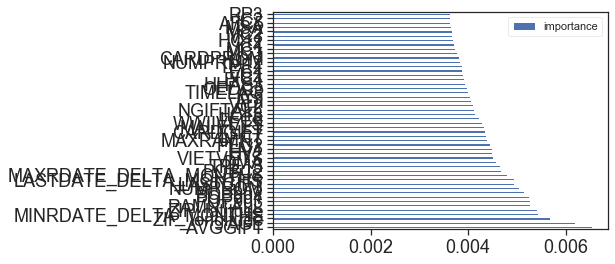

In [31]:
importances.sort_values(by="importance", ascending=False).head(50).plot(kind="barh")

Using this approach, we end up with 274 features. So it's a little less than with PCA, but still far more than the selection by boruta.

In [32]:
model = SelectFromModel(clf, prefit=True)
X_sfm = model.transform(Xy["data"].values)
X_sfm.shape               

(95412, 274)

In [33]:
selected_features = Xy["data"].columns.values[model.get_support()]

In [34]:
selected_features

array(['AGE', 'INCOME', 'WEALTH1', 'HIT', 'MALEVET', 'VIETVETS',
       'WWIIVETS', 'LOCALGOV', 'STATEGOV', 'FEDGOV', 'WEALTH2',
       'PEPSTRFL', 'POP901', 'POP902', 'POP903', 'POP90C4', 'POP90C5',
       'ETH1', 'ETH2', 'ETH4', 'ETH5', 'ETH13', 'AGE901', 'AGE902',
       'AGE903', 'AGE904', 'AGE905', 'AGE906', 'AGE907', 'CHIL1', 'CHIL2',
       'CHIL3', 'AGEC1', 'AGEC2', 'AGEC3', 'AGEC4', 'AGEC5', 'AGEC6',
       'AGEC7', 'CHILC1', 'CHILC2', 'CHILC3', 'CHILC4', 'CHILC5',
       'HHAGE1', 'HHAGE2', 'HHAGE3', 'HHN1', 'HHN2', 'HHN3', 'HHN4',
       'HHN5', 'HHN6', 'MARR1', 'MARR2', 'MARR3', 'MARR4', 'HHP1', 'HHP2',
       'DW1', 'DW2', 'DW3', 'DW4', 'DW5', 'DW6', 'HV1', 'HV2', 'HU1',
       'HU2', 'HU3', 'HU4', 'HU5', 'HHD1', 'HHD2', 'HHD3', 'HHD4', 'HHD5',
       'HHD6', 'HHD7', 'HHD9', 'HHD10', 'HHD11', 'HHD12', 'ETHC1',
       'ETHC2', 'ETHC3', 'ETHC5', 'HVP1', 'HVP2', 'HVP3', 'HVP4', 'HVP5',
       'HVP6', 'HUR1', 'HUR2', 'RHP1', 'RHP2', 'HUPA1', 'HUPA2', 'HUPA3',
       'HUPA4', '